## **Importing Important Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

If the GPU is available use it for the computation otherwise use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
IMAGE_SIZE = 16


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=composed)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=composed) 

# **We have 10 types of clothes in FashionMNIST dataset.**
Making a method that return the name of class for the label number. ex. if the label is 5, we return Sandal.

In [4]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [5]:
len(train_set)

60000

In [6]:
from collections import Counter
# labels in training set
train_classes = [label for _, label in train_set]
Counter(train_classes)

Counter({0: 6000,
         1: 6000,
         2: 6000,
         3: 6000,
         4: 6000,
         5: 6000,
         6: 6000,
         7: 6000,
         8: 6000,
         9: 6000})

Playing with data and displaying some images using matplotlib imshow() method.

9


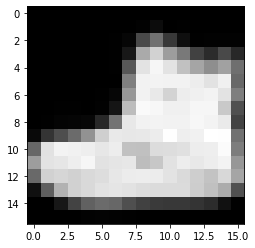

In [7]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [8]:
my_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(my_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 16, 16]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

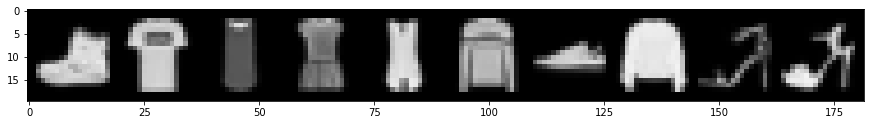

In [9]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [10]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

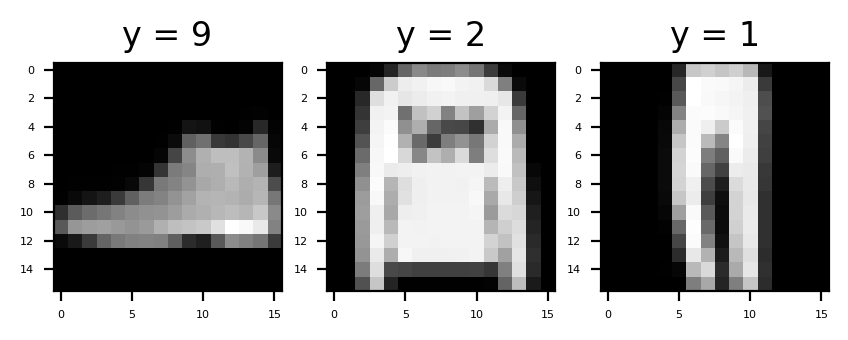

In [11]:
IMAGE_SIZE = 16

my_dpi = 200
fig = plt.figure(figsize=(5, 5), dpi=my_dpi)

# ============ AX1 ============ 
ax1 = fig.add_subplot(1, 3, 1)
ax1.xaxis.set_tick_params(labelsize=4)
ax1.yaxis.set_tick_params(labelsize=4)
ax1 = show_data(test_set[0])

# ============ AX2 ============ 
ax2 = fig.add_subplot(1, 3, 2)
ax2.xaxis.set_tick_params(labelsize=4)
ax2.yaxis.set_tick_params(labelsize=4)
ax2 = show_data(test_set[1])
# ============ AX3 ============ 
ax3 = fig.add_subplot(1, 3, 3)
ax3.xaxis.set_tick_params(labelsize=4)
ax3.yaxis.set_tick_params(labelsize=4)
ax3 = show_data(test_set[2])

# Building a CNN

In [29]:
class FashionCNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32, number_of_classes=10):
        super(FashionCNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        out=self.bn_fc1(x)
        return out

In [30]:
# Define the function to train model
cost_list=[]
accuracy_list=[]
N_test=len(test_set)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
    return accuracy_list, cost_list

In [31]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=5000, shuffle=False)

# Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*   Defining a Loss function. we're using CrossEntropyLoss() here.
*   Using Adam algorithm for optimization purpose.

### Training a network and Testing it on test dataset

In [32]:
model = FashionCNN()
model.to(device)

# Define the loss
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

accuracy_list, cost_list = train_model(5)

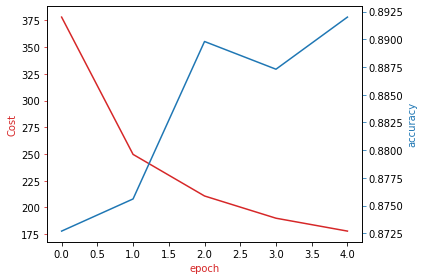

In [33]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()